In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [18]:
from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [19]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [20]:
data = pd.read_pickle('./data/rp-data.pickle')
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.0,5735.000000,5735.000000,5735.000000,5735.00000
mean,10.054577,585.904446,1.445336,584.709459,0.020009,3970.305144,3826.666908,12.123627,28.033653,37.155013,108.791805,1.010856,0.988570,0.994532,1.001883,1.005510,0.207906,31.745737,54.023540,147.813601,1.0,0.047602,1.873583,0.988221,1.02694
std,6.839047,371.356752,0.961285,369.419134,0.941834,947.560612,1011.749091,3.356021,2.614471,7.556406,15.702953,0.299620,0.059088,0.045185,0.118457,0.118344,0.044695,35.855732,26.374069,58.382610,0.0,0.420109,16.313341,0.036752,0.06850
min,1.000000,245.000000,1.000000,-1.000000,-13.710000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.00000
25%,5.000000,352.000000,1.000000,351.455000,-0.280000,3300.000000,2992.680000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.830000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.00000
50%,9.000000,448.000000,1.000000,447.830000,-0.020000,4000.000000,3819.200000,11.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.240000,44.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.00000
75%,13.000000,692.000000,1.000000,690.490000,0.270000,4500.000000,4455.000000,14.000000,30.000000,41.000000,115.000000,1.200000,1.000000,1.000000,1.000000,1.000000,0.235000,43.125000,66.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.00000
max,42.000000,3440.000000,6.000000,3440.330000,8.910000,6300.000000,6916.140000,23.000000,35.000000,74.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.800000,213.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.44000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.72,-0.28,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.77,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.43,0.43,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.77,538.37,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.10,0.10,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.77,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.99,-0.01,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.43,937.95,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,715.12,0.12,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.15,750.07,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [21]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [22]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"] - RP(x)


In [23]:
filename = f"./results/least-squares-fit-{digest(data, x0)}.npy"
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.562e-01  2.545e-01 ...  2.195e-01  9.953e-01]
       cost: 970.1076591930191
       grad: [-1.729e-05  1.028e-04 ...  6.970e-05 -7.303e-04]
 optimality: 1.1403826778405346
       nfev: 50
       njev: 35

In [24]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
2539,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1699.341637,13.658363,186.550879
1118,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,18.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1891.143160,12.856840,165.298346
1967,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,21.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1742.923100,11.076900,122.697724
2012,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,16.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.595354,9.404646,88.447361
2363,Togekiss,TogekissGentle103Skill Trigger M,10.0,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.791042,9.208958,84.804916
387,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1430.804521,9.195479,84.556840
359,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,19.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.934826,9.065174,82.177388
2478,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,23.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1752.392235,8.607765,74.093621
571,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,15.0,2.0,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.393086,8.606914,74.078972
2772,Weepinbell,WeepinbellNeutral302Energy Recovery BonusInven...,30.0,12.0,2.0,-,-,Energy Recovery Bonus,Inventory Up M,1192.0,1183.733125,8.266875,68.341218


intercept,-0.00245664
intercept_stderr,0.0210983
pvalue,0.503818
rvalue,-0.00882912
slope,-0.00115998
stderr,0.0017351


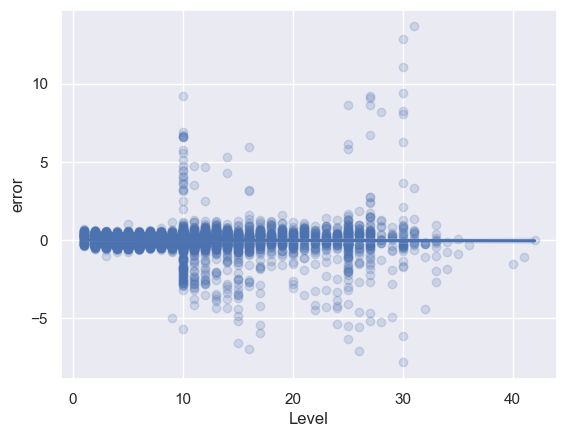

In [25]:
# Plot error vs level

err = df[["Level","error"]]
g = sns.regplot(data=err, x="Level", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,0.0200726
intercept_stderr,0.0177874
pvalue,0.00229502
rvalue,-0.0463742
slope,-0.00612154
stderr,0.00200643


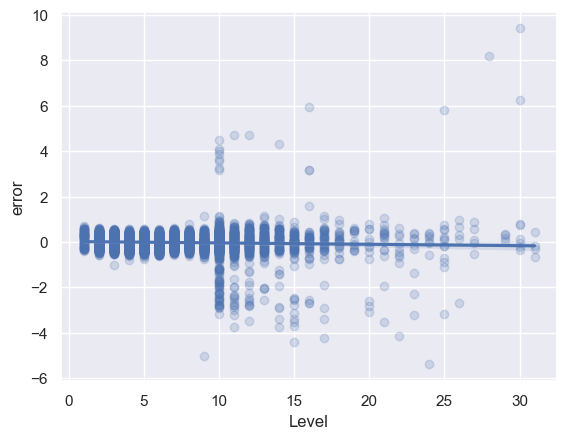

In [26]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error"]].loc[df["MS lvl"]==1]
g = sns.regplot(data=err, x="Level", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

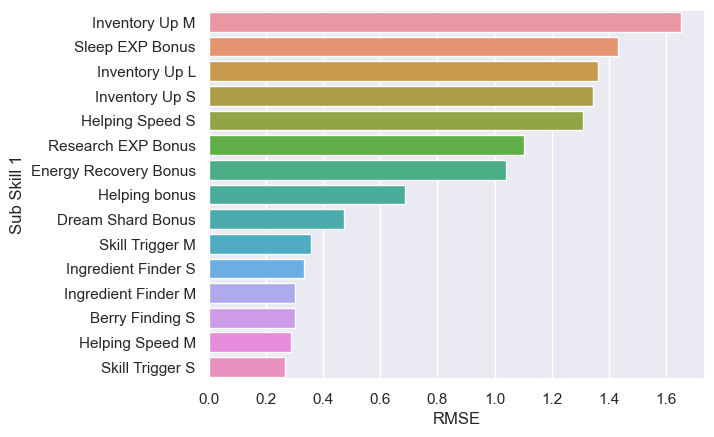

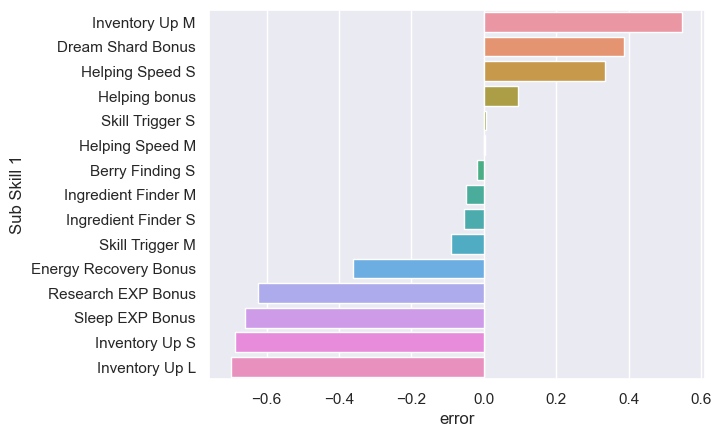

In [27]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')]

intercept,0.0200726
intercept_stderr,0.0177874
pvalue,0.00229502
rvalue,-0.0463742
slope,-0.00612154
stderr,0.00200643


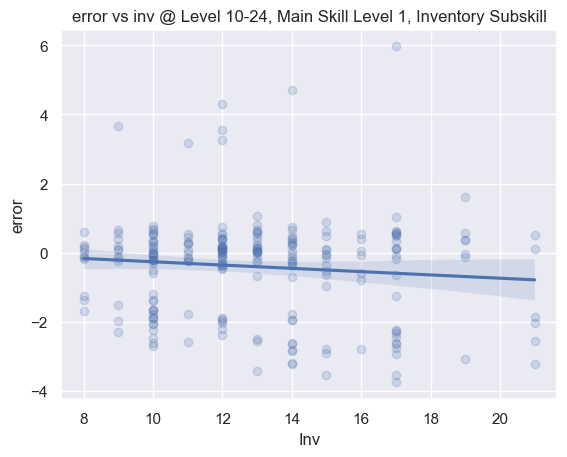

In [28]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"].str.contains("Inventory")) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')]

intercept,0.0200726
intercept_stderr,0.0177874
pvalue,0.00229502
rvalue,-0.0463742
slope,-0.00612154
stderr,0.00200643


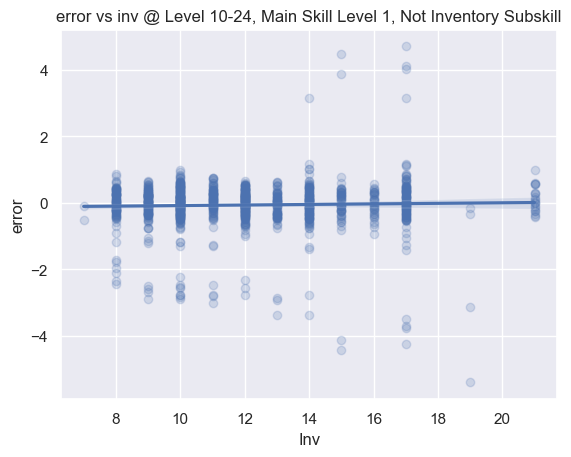

In [29]:
# Let's see what happens at level 10-24, main skill 1, and not inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]>9) & (df["Level"]<25) & (df["MS lvl"]==1) & ( ~df["Sub Skill 1"].str.contains("Inventory") ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

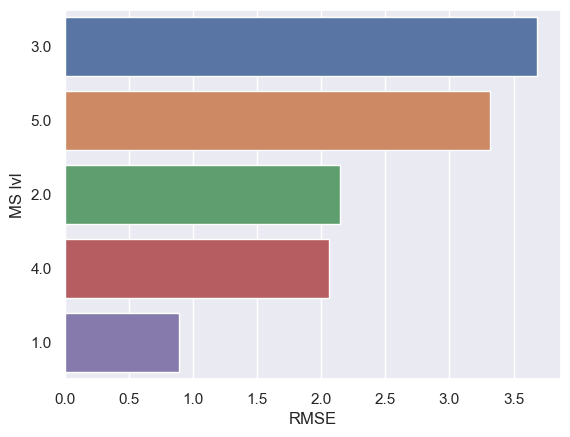

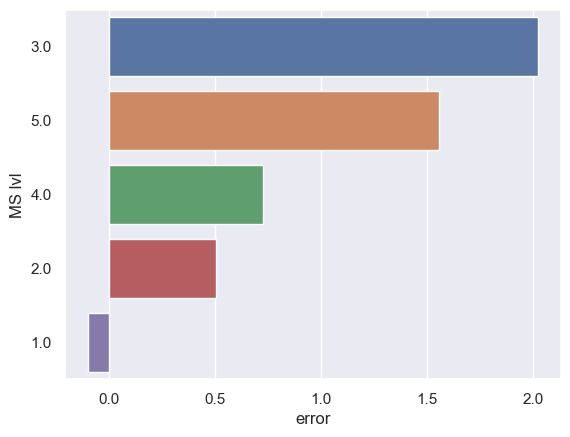

In [30]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


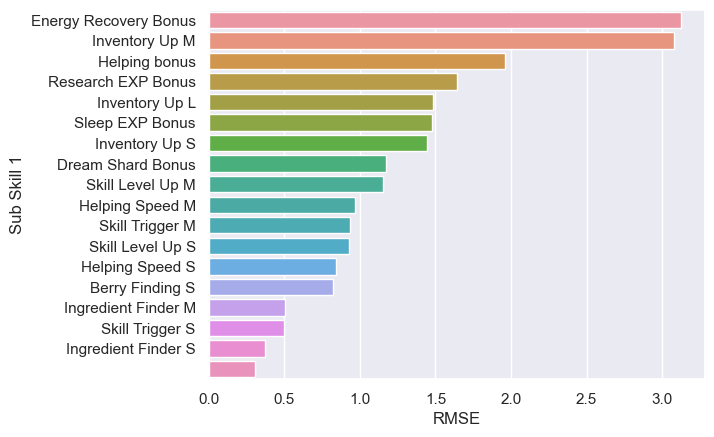

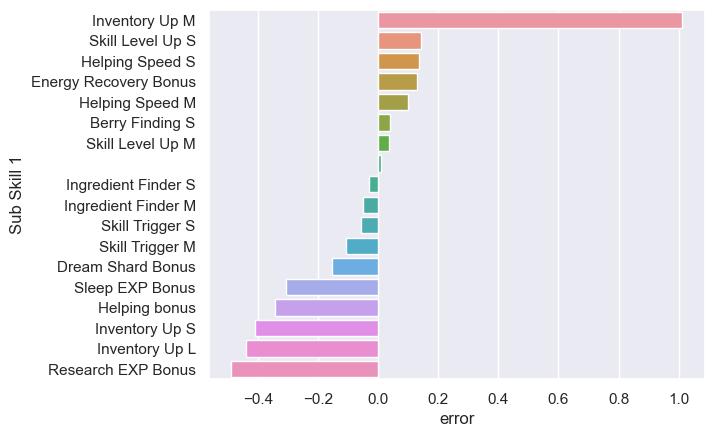

In [31]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

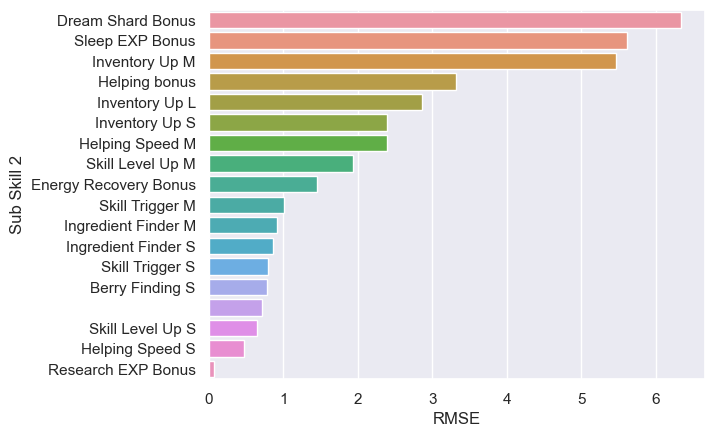

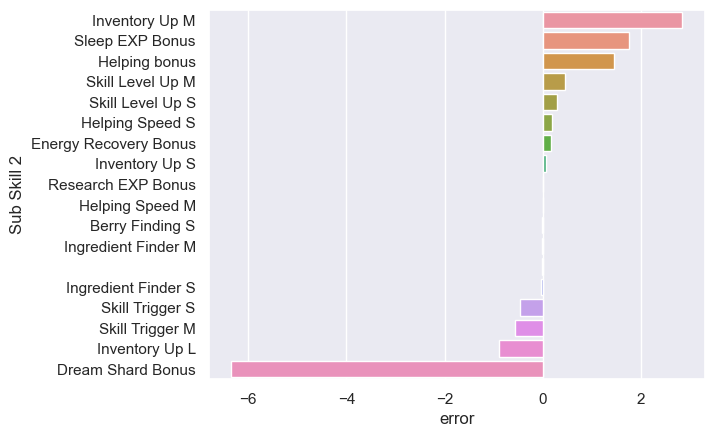

In [32]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")